In [17]:
%pip install git+https://github.com/geoopt/geoopt.git

  Cloning https://github.com/geoopt/geoopt.git to /tmp/pip-req-build-h52btm3q
  Running command git clone -q https://github.com/geoopt/geoopt.git /tmp/pip-req-build-h52btm3q
  Created wheel for geoopt: filename=geoopt-0.1.2-py3-none-any.whl size=66728 sha256=89341667c95992b1d26144031bbee8603a3b1bbcf48dc770363c6643aaac6c95
  Stored in directory: /tmp/pip-ephem-wheel-cache-948ai21q/wheels/e9/b9/1f/4238e702b8889c5329cc24bb3c1d020ab33de17df8ee1e8da4
Successfully built geoopt
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import geoopt
import torch
import itertools
import torch.nn as nn
import numpy as np
import tqdm
%matplotlib inline

In [2]:
class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, ball, dim, depth, numberOfChildren=2, dist_children=1, sigma_sibling=2, param=1, numberOfsiblings=1):
        assert numberOfChildren == 2
        self.dim = int(dim)
        self.ball = ball
        self.root = ball.origin(self.dim)
        self.sigma_sibling = sigma_sibling
        self.depth = int(depth)
        self.dist_children = dist_children
        self.numberOfChildren = int(numberOfChildren)
        self.numberOfsiblings = int(numberOfsiblings)  
        self.__class_counter = itertools.count()
        self.origin_data, self.origin_labels, self.data, self.labels = map(torch.detach, self.bst())
        self.num_classes = self.origin_labels.max().item()+1
        #self.data = ball.mobius_add(self.data, -ball.weighted_midpoint(self.data)).detach()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, labels = self.data[idx], self.labels[idx]
        return data, labels, labels.max(-1).values

    def get_children(self, parent_value, parent_label, current_depth, offspring=True):
        if offspring:
            numberOfChildren = self.numberOfChildren
            sigma = self.dist_children
        else:
            numberOfChildren = self.numberOfsiblings
            sigma = self.sigma_sibling
        if offspring:
            direction = torch.randn_like(parent_value)
            parent_value_n = parent_value / parent_value.norm().clamp_min(1e-15)
            direction -= parent_value_n @ direction * parent_value_n
            child_value_1 = ball.geodesic_unit(torch.tensor(sigma), parent_value, direction)
            child_value_2 = ball.geodesic_unit(torch.tensor(sigma), parent_value, -direction)
            child_label_1 = parent_label.clone()
            child_label_1[current_depth] = next(self.__class_counter)
            child_label_2 = parent_label.clone()
            child_label_2[current_depth] = next(self.__class_counter)
            children = [
                (child_value_1, child_label_1),
                (child_value_2, child_label_2)
            ]
        else:
            children = []
            for i in range (numberOfChildren):
                child_value = ball.random(self.dim, mean=parent_value, std=sigma ** .5)
                child_label = parent_label.clone()
                children.append((child_value, child_label))
        return children

    def bst(self):
        label = -torch.ones(self.depth+1, dtype=torch.long)
        label[0] = next(self.__class_counter)
        queue = [(self.root, label, 0)]
        visited = []
        labels_visited = []
        values_clones = []
        labels_clones = []
        while len(queue) > 0:
            current_node, current_label, current_depth = queue.pop(0)
            visited.append(current_node)
            labels_visited.append(current_label)
            if current_depth < self.depth:
                children = self.get_children(current_node, current_label, current_depth)
                for child in children:
                    queue.append((child[0], child[1], current_depth + 1)) 
            if current_depth <= self.depth:
                clones = self.get_children(current_node, current_label, current_depth, False)
                for clone in clones:
                    values_clones.append(clone[0])
                    labels_clones.append(clone[1])
        length = int(((self.numberOfChildren) ** (self.depth + 1) - 1) / (self.numberOfChildren - 1))
        length_leaves = int(self.numberOfChildren**self.depth)
        images = torch.cat([i for i in visited]).reshape(length, self.dim)
        labels_visited = torch.cat([i for i in labels_visited]).reshape(length, self.depth+1)[:,:self.depth]
        values_clones = torch.cat([i for i in values_clones]).reshape(self.numberOfsiblings*length, self.dim)
        labels_clones = torch.cat([i for i in labels_clones]).reshape(self.numberOfsiblings*length, self.depth+1)
        return images, labels_visited, values_clones, labels_clones

In [3]:
def add_geodesic_grid(ax, manifold, line_width=0.1):

    # define geodesic grid parameters
    N_EVALS_PER_GEODESIC = 10000
    STYLE = "--"
    COLOR = "gray"
    LINE_WIDTH = line_width

    # get manifold properties
    K = manifold.c.item()
#     R = manifold.radius.item()
    R = 1

    # get maximal numerical distance to origin on manifold
    if K < 0:
        # create point on R
        r = torch.tensor((R, 0.0), dtype=manifold.dtype)
        # project point on R into valid range (epsilon border)
        r = manifold.projx(r)
        # determine distance from origin
        max_dist_0 = manifold.dist0(r).item()
    else:
        max_dist_0 = np.pi * R
    # adjust line interval for spherical geometry
    circumference = 2*np.pi*R

    # determine reasonable number of geodesics
    # choose the grid interval size always as if we'd be in spherical
    # geometry, such that the grid interpolates smoothly and evenly
    # divides the sphere circumference
    n_geodesics_per_circumference = 4 * 6  # multiple of 4!
    n_geodesics_per_quadrant = n_geodesics_per_circumference // 2
    grid_interval_size = circumference / n_geodesics_per_circumference
    if K < 0:
        n_geodesics_per_quadrant = int(max_dist_0 / grid_interval_size)

    # create time evaluation array for geodesics
    if K < 0:
        min_t = -1.2*max_dist_0
    else:
        min_t = -circumference/2.0
    t = torch.linspace(min_t, -min_t, N_EVALS_PER_GEODESIC)[:, None]

    # define a function to plot the geodesics
    def plot_geodesic(gv):
        ax.plot(*gv.t().numpy(), STYLE, color=COLOR, linewidth=LINE_WIDTH)

    # define geodesic directions
    u_x = torch.tensor((0.0, 1.0))
    u_y = torch.tensor((1.0, 0.0))

    # add origin x/y-crosshair
    o = torch.tensor((0.0, 0.0))
    if K < 0:
        x_geodesic = manifold.geodesic_unit(t, o, u_x)
        y_geodesic = manifold.geodesic_unit(t, o, u_y)
        plot_geodesic(x_geodesic)
        plot_geodesic(y_geodesic)
    else:
        # add the crosshair manually for the sproj of sphere
        # because the lines tend to get thicker if plotted
        # as done for K<0
        ax.axvline(0, linestyle=STYLE, color=COLOR, linewidth=LINE_WIDTH)
        ax.axhline(0, linestyle=STYLE, color=COLOR, linewidth=LINE_WIDTH)

    # add geodesics per quadrant
    for i in range(1, n_geodesics_per_quadrant):
        i = torch.as_tensor(float(i))
        # determine start of geodesic on x/y-crosshair
        x = manifold.geodesic_unit(i*grid_interval_size, o, u_y)
        y = manifold.geodesic_unit(i*grid_interval_size, o, u_x)

        # compute point on geodesics
        x_geodesic = manifold.geodesic_unit(t, x, u_x)
        y_geodesic = manifold.geodesic_unit(t, y, u_y)

        # plot geodesics
        plot_geodesic(x_geodesic)
        plot_geodesic(y_geodesic)
        if K < 0:
            plot_geodesic(-x_geodesic)
            plot_geodesic(-y_geodesic)

In [10]:
dataset.data.T

tensor([[ 0.0331, -0.1574,  0.3017,  ..., -0.5753, -0.4943, -0.5835],
        [ 0.0326, -0.0261, -0.0872,  ..., -0.3140, -0.3511, -0.1322]])

In [13]:
dataset.labels.max(-1).values.float()

tensor([ 0.,  0.,  0.,  ..., 14., 14., 14.])

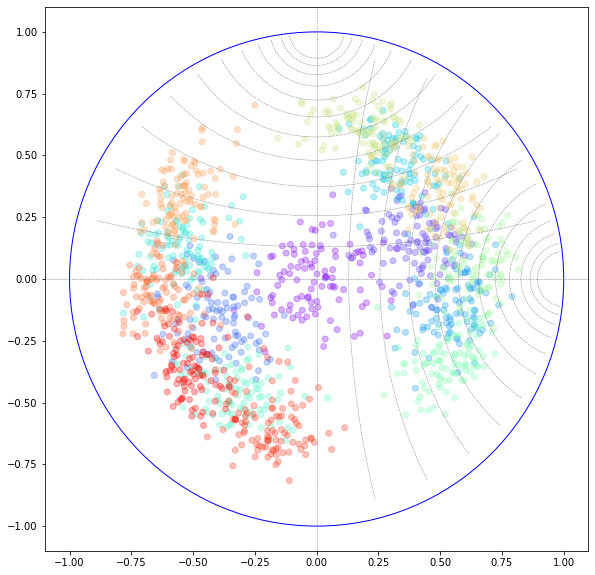

In [9]:
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, fill=False, color="b")
add_geodesic_grid(plt.gca(), ball, 0.5)
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
plt.scatter(*dataset.data.T, 
            c=dataset.labels.max(-1).values.float() / num_classes, 
            alpha=.3, cmap="rainbow");

In [98]:
# classifier = torch.nn.Sequential(
#     Distance2PoincareHyperplanes(2, 10, ball=ball),
#     torch.nn.Linear(10, 32),
#     torch.nn.ReLU(),
#     torch.nn.Linear(32, num_classes),
# )


In [10]:
class ToPoincare(torch.nn.Module):
    def __init__(self, in_dim, ball):
        super().__init__()
        self.x = torch.zeros(in_dim)
        self.ball_ = ball
        
    def forward(self, u):
        return self.ball_.expmap(self.x, u)
    
class Criterion(nn.Module):
    def __init__(self, ball):
        super().__init__()
        self.ball = ball
        
    def forward(self, u, v, same):
        if same:
            return self.ball.dist(u, v)
        else:
            return 10.-self.ball.dist(u, v)

classifier = torch.nn.Sequential(
    Distance2PoincareHyperplanes(4, 10, ball=ball),
    torch.nn.Linear(10, 4),
    torch.nn.ReLU(),
#     torch.nn.Linear(32, 2),
#     torch.nn.ReLU(),
    ToPoincare(4, ball)
)

In [8]:
ball = geoopt.PoincareBall()
torch.manual_seed(42)
dataset = SyntheticDataset(ball, dim=2, depth=3, numberOfsiblings=100, sigma_sibling=0.02, dist_children=1)
num_classes = dataset.num_classes
num_classes

15

In [12]:
optim = geoopt.optim.RiemannianAdam(classifier.parameters(), lr=1e-3)
loader = torch.utils.data.DataLoader(dataset, 100, shuffle=True)
# criterion = torch.nn.CrossEntropyLoss()
criterion = Criterion(ball)

In [15]:
with tqdm.trange(100) as _range:
    for epoch in _range:
        for p, _, l in loader:
            optim.zero_grad()
            out = classifier(p)
            idx = np.random.choice(len(l), size=2, replace=False)
            l1, l2 = l[idx[0]], l[idx[1]]
            u1, u2 = out[idx[0]], out[idx[1]]
            loss = criterion(u1, u2, l1==l2)
            loss.backward()
            optim.step()
            _range.set_description(f"loss={loss.item()}")

loss=-1.3347063064575195: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s] 


In [24]:
out.shape

torch.Size([500, 4])

In [16]:
test_loader = torch.utils.data.DataLoader(dataset, 1000, shuffle=True)
for p, _, l in test_loader:
    out = classifier(p)
    idx = np.random.choice(len(l), size=2, replace=False)
    l1, l2 = l[idx[0]], l[idx[1]]
    u1, u2 = out[idx[0]], out[idx[1]]
    loss = criterion(u1, u2, l1==l2)

In [18]:
from poincare_kmeans import PoincareKMeans as KMeans

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
model = KMeans(4, num_classes, verbose=True)
# clusters = model.fit_predict(p.numpy())
clusters = model.fit_predict(out.detach().cpu().numpy())

Num Samples: 500
Iteration: 0 - Best Inertia: 12382.54765157872
Num Samples: 500
Iteration: 1 - Best Inertia: 12382.54765157872
Num Samples: 500
Iteration: 2 - Best Inertia: 12382.54765157872
Num Samples: 500
Iteration: 3 - Best Inertia: 12382.54765157872
Num Samples: 500
Iteration: 4 - Best Inertia: 12382.54765157872
Num Samples: 500
Iteration: 5 - Best Inertia: 12382.54765157872
Num Samples: 500
Iteration: 6 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 7 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 8 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 9 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 10 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 11 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 12 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 13 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration: 14 - Best Inertia: 12319.740913427626
Num Samples: 500
Iteration

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(-confusion_matrix(l, clusters))
imap = dict(zip(col_ind, row_ind))
clusters_mapped = [imap[i] for i in clusters]
confusion_matrix(l, clusters_mapped)

array([[13,  0,  0,  0,  0,  0,  0,  1,  3,  0,  0,  0,  4,  4,  8],
       [12,  0,  0,  0,  0,  0,  0, 10,  1,  6,  0,  0,  0,  0,  1],
       [ 0,  0, 13,  0,  0,  0,  0,  0,  0,  0,  0,  1,  5, 21,  3],
       [ 1,  1,  0,  9,  0,  0,  2, 12,  4,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  2,  0, 28,  0,  0,  0,  0,  1],
       [ 0,  0,  2,  0,  0, 12,  0,  0,  0,  0,  0,  9,  9,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 22],
       [ 0,  3,  0,  7,  0,  0,  0, 17,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  3,  0,  2,  1, 18,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  8,  0, 22,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  7,  0,  0,  0,  0,  0,  9,  1,  5,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0,  0,  0,  0,  1, 21,  1,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 14, 10],
       [ 0,  0,  1,  0,  0,  0,  0

In [23]:
accuracy_score(l, clusters_mapped)

0.398

RuntimeError: shape '[1000, 1000, 15]' is invalid for input of size 32000000

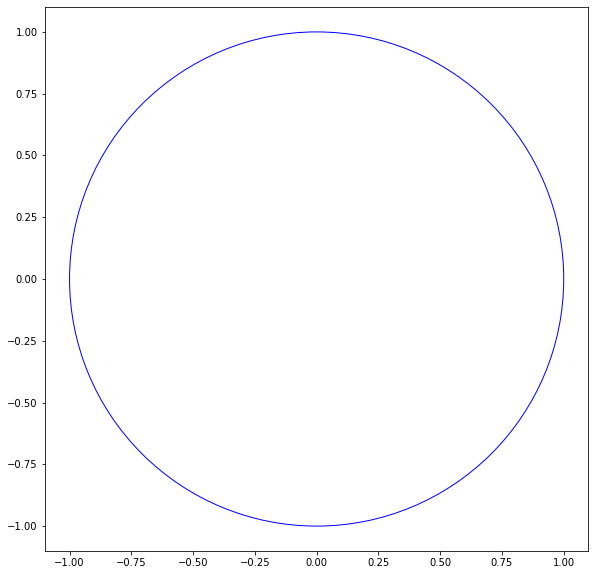

In [74]:
import matplotlib.colors
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, fill=False, color="b")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
radius = 1.
coords = torch.linspace(-radius, radius, 1000)
xx, yy = torch.meshgrid(coords, coords)
dist2 = xx ** 2 + yy ** 2
mask = dist2 <= radius ** 2
grid = torch.stack([xx, yy], dim=-1)
probs = classifier(grid.view(-1, 2)).reshape(*xx.shape, num_classes).softmax(-1)
probs[~mask] = np.nan

cmap = plt.get_cmap("rainbow")
for c in range(num_classes):
    base_color = cmap(c / num_classes)
    tmp_cmap = matplotlib.colors.LinearSegmentedColormap("tmp", dict(
        red=[[0, base_color[0], base_color[0]], [1, base_color[0], base_color[0]]],
        green=[[0, base_color[1], base_color[1]], [1, base_color[1], base_color[1]]],
        blue=[[0, base_color[2], base_color[2]], [1, base_color[2], base_color[2]]],
        alpha=[[0, 0, 0], [1, 1, 1]],
    ))
    plt.contourf(
        grid[..., 0], grid[..., 1], probs[..., c].detach().numpy(), levels=100, cmap=tmp_cmap
    )

add_geodesic_grid(plt.gca(), ball, 0.5)
plt.scatter(*dataset.data.T, c=dataset.labels.max(-1).values, cmap="rainbow", edgecolors='black');

In [9]:
class Distance2PoincareHyperplanes(torch.nn.Module):
    n = 0
    # 1D, 2D versions of this class ara available with a one line change
    # class Distance2PoincareHyperplanes2d(Distance2PoincareHyperplanes):
    #     n = 2

    def __init__(
        self,
        plane_shape: int,
        num_planes: int,
        signed=True,
        squared=False,
        *,
        ball,
        std=1.0,
    ):
        super().__init__()
        self.signed = signed
        self.squared = squared
        # Do not forget to save Manifold instance to the Module
        self.ball = ball
        self.plane_shape = geoopt.utils.size2shape(plane_shape)
        self.num_planes = num_planes

        # In a layer we create Manifold Parameters in the same way we do it for
        # regular pytorch Parameters, there is no difference. But geoopt optimizer
        # will recognize the manifold and adjust to it
        self.points = geoopt.ManifoldParameter(
            torch.empty(num_planes, plane_shape), manifold=self.ball
        )
        self.std = std
        # following best practives, a separate method to reset parameters
        self.reset_parameters()

    def forward(self, input):
        input_p = input.unsqueeze(-self.n - 1)
        points = self.points.permute(1, 0)
        points = points.view(points.shape + (1,) * self.n)

        distance = self.ball.dist2plane(
            x=input_p, p=points, a=points, signed=self.signed, dim=-self.n - 2
        )
        if self.squared and self.signed:
            sign = distance.sign()
            distance = distance ** 2 * sign
        elif self.squared:
            distance = distance ** 2
        return distance

    def extra_repr(self):
        return (
            "plane_shape={plane_shape}, "
            "num_planes={num_planes}, "
            .format(**self.__dict__)
        )

    @torch.no_grad()
    def reset_parameters(self):
        direction = torch.randn_like(self.points)
        direction /= direction.norm(dim=-1, keepdim=True)
        distance = torch.empty_like(self.points[..., 0]).normal_(std=self.std)
        self.points.set_(self.ball.expmap0(direction * distance.unsqueeze(-1)))